In [2]:
import pyclipper
import Polygon as plg
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [26]:
polys = np.array(
    [
        [300, 300],
        [500, 400],
        [400, 600],
        [100, 500]
    ],
)

mask = np.zeros(shape=(1024, 1024), dtype=np.uint8)

In [37]:
import cv2
img = cv2.drawContours(mask, [polys.reshape((-1, 2)).astype(np.int32)], -1, 1, -1)

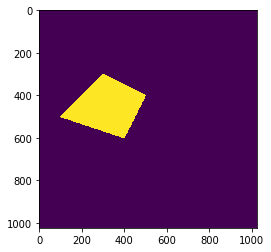

In [38]:
plt.imshow(img)

In [39]:
distance_map = cv2.distanceTransform(img, 2, 5)

In [40]:
cv2.normalize(distance_map, distance_map, 0, 1, cv2.NORM_MINMAX)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

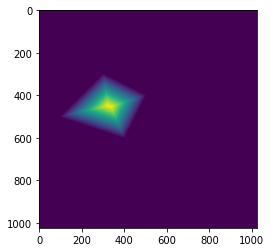

In [41]:
plt.imshow(distance_map)

In [112]:
### process border
def dist(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def perimeter(bbox):
    peri = 0.0
    for i in range(bbox.shape[0]):
        peri += dist(bbox[i], bbox[(i + 1) % bbox.shape[0]])
    return peri
def shrink(bboxes, rate, max_shr=20, direct=1):
    rate = rate * rate
    shrinked_bboxes = []
    for bbox in bboxes:
        area = plg.Polygon(bbox).area()
        peri = perimeter(bbox)

        pco = pyclipper.PyclipperOffset()
        # if direct==-1:
        #     bbox = pyclipper.scale_to_clipper(bbox)
        pco.AddPath(bbox, pyclipper.JT_ROUND, pyclipper.ET_CLOSEDPOLYGON)
        offset = min((int)(area * (1 - rate) / (peri + 0.001) + 0.5), max_shr)
        print(f'offset : {offset}')
        shrinked_bbox = pco.Execute(-(offset * direct))
        if len(shrinked_bbox) == 0:
            shrinked_bboxes.append(bbox)
            continue
        
        shrinked_bbox = np.array(shrinked_bbox)[0]
        if shrinked_bbox.shape[0] <= 2:
            shrinked_bboxes.append(bbox)
            continue
        
        shrinked_bboxes.append(shrinked_bbox)
    
    return np.array(shrinked_bboxes)

offset : 20
offset : 20


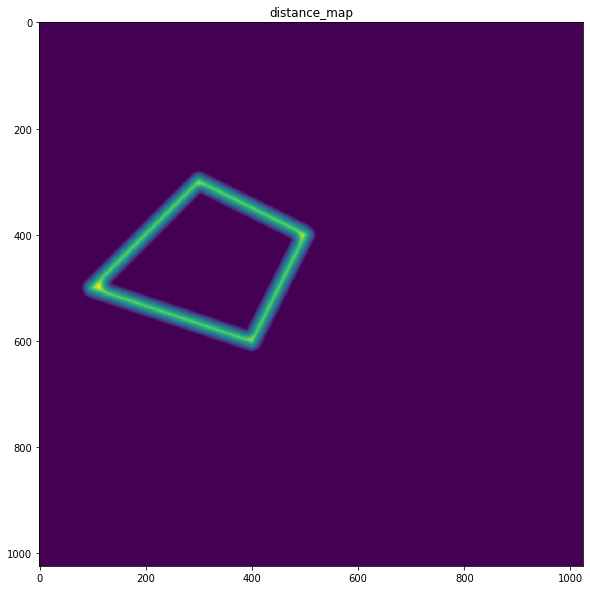

In [121]:
mask = np.zeros(shape=(1024, 1024), dtype=np.uint8)
shrink_boxes = shrink(polys.reshape((1, -1, 2)), 0.4)
unshrink_boxes = shrink(polys.reshape((1, -1, 2)), 0.4, direct=-1)
img = cv2.drawContours(mask, [unshrink_boxes.reshape((-1, 2)).astype(np.int32)], -1, 1, -1)
# img = cv2.drawContours(img, [polys.reshape((-1, 2)).astype(np.int32)], -1, 0, -1)
img = cv2.drawContours(img, [shrink_boxes.reshape((-1, 2)).astype(np.int32)], -1, 0, -1)
plt.figure(figsize=(10, 10))
plt.title("map")
plt.imshow(img)
distance_map = cv2.distanceTransform(img, 2, 5)
cv2.normalize(distance_map, distance_map, 0, 1, cv2.NORM_MINMAX)
plt.title('distance_map')
plt.imshow(distance_map)

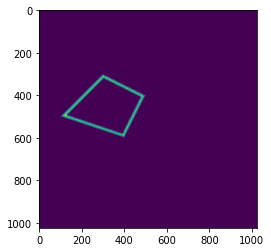

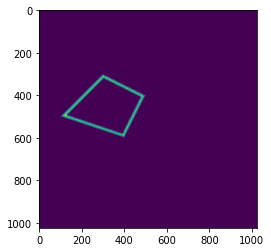

In [69]:
len(np.where(distance_map > 0.7)[0])

1961